Classification Report:
                precision    recall  f1-score   support

informational       0.74      0.67      0.70        21
 navigational       0.80      0.65      0.72        80
transactional       0.95      0.97      0.96       656

     accuracy                           0.93       757
    macro avg       0.83      0.76      0.79       757
 weighted avg       0.93      0.93      0.93       757

Confusion Matrix:
 [[ 14   0   7]
 [  0  52  28]
 [  5  13 638]]


<Figure size 640x480 with 0 Axes>

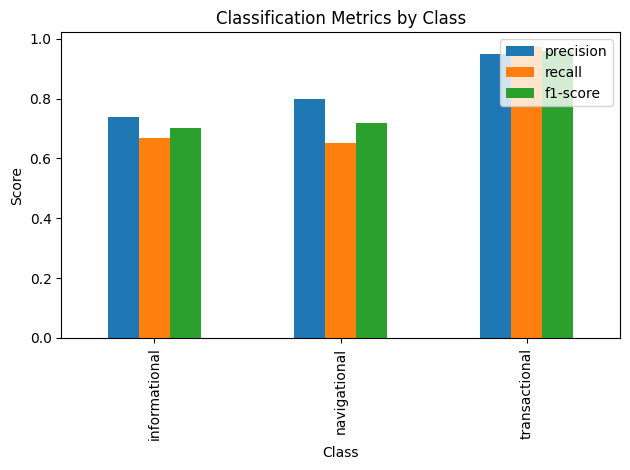

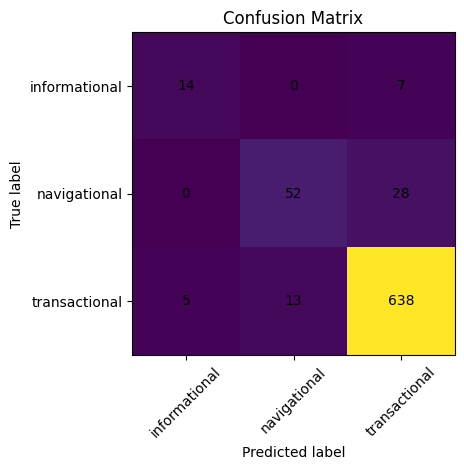

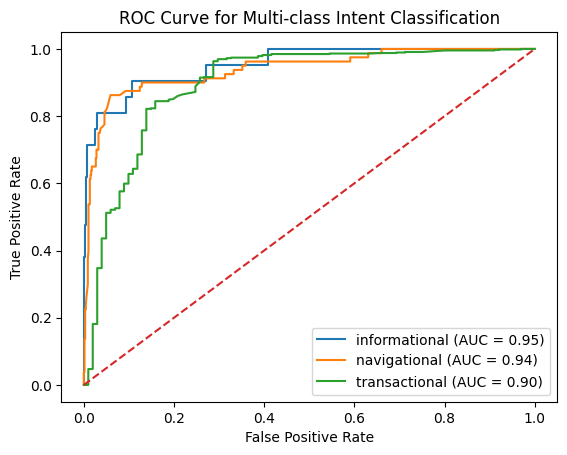

In [2]:
import pandas as pd
import re
import unicodedata
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)

# 1) Load data
df = pd.read_csv('./queries.csv')

# 2) Create 'intent' label
def assign_intent(row):
    if row['navigational']:
        return 'navigational'
    elif row['quote_question']:
        return 'informational'
    else:
        return 'transactional'
df['intent'] = df.apply(assign_intent, axis=1)

# 3) Filter out ambiguous
df = df[df['ambiguous'] == False].reset_index(drop=True)

# 4) Clean text
def clean_text(text):
    text = text.lower()
    text = unicodedata.normalize('NFKD', text).encode('ascii','ignore').decode('utf-8')
    text = re.sub(r'[^a-z0-9\s\?\.]', ' ', text)  # allow dot for .com
    return re.sub(r'\s+', ' ', text).strip()
df['clean_text'] = df['text'].fillna('').apply(clean_text)

# 5) Linguistic features
wh_pattern = r'\b(?:what|how|when|where|why)\b'
df['has_wh_word'] = df['clean_text'].str.contains(wh_pattern).astype(int)
df['char_length'] = df['clean_text'].apply(len)
df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))

# 5b) New feature: presence of ".com"
df['has_dot_com'] = df['clean_text'].str.contains(r'\.com\b').astype(int)

# 6) TF-IDF vectorization
vectorizer = TfidfVectorizer(stop_words='english', min_df=2, max_df=0.9, ngram_range=(1,2))
X_text = vectorizer.fit_transform(df['clean_text'])

# 7) Scale numeric features
scaler = StandardScaler()
X_num = scaler.fit_transform(df[['has_wh_word', 'char_length', 'word_count', 'has_dot_com']])
X_num_sparse = csr_matrix(X_num)

# 8) Combine features
X = hstack([X_text, X_num_sparse])

# 9) Train-test split
y = df['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    stratify=y, random_state=42)
# 10) Train SVM
model = LinearSVC(class_weight='balanced', random_state=42, dual=False, max_iter=20000)
model.fit(X_train, y_train)

# 11) Evaluate
y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# 12) Save artifacts
with open('./tfidf_vectorizer.pkl','wb') as f: pickle.dump(vectorizer, f)
with open('./svm_intent_model.pkl','wb') as f: pickle.dump(model, f)

# 13) Generate metrics
report_dict = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose().drop(['accuracy','macro avg','weighted avg'])

conf_mat = confusion_matrix(y_test, y_pred)
labels = df_report.index.tolist()

# 14) Plot Precision, Recall, F1-score
plt.figure()
df_report[['precision','recall','f1-score']].plot(kind='bar')
plt.title('Classification Metrics by Class')
plt.xlabel('Class')
plt.ylabel('Score')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# 15) Plot Confusion Matrix
plt.figure()
plt.imshow(conf_mat, interpolation='nearest')
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks(range(len(labels)), labels, rotation=45)
plt.yticks(range(len(labels)), labels)
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        plt.text(j, i, conf_mat[i, j], ha='center', va='center')
plt.tight_layout()
plt.show()

# 16) Compute decision scores for ROC
y_score = model.decision_function(X_test)

# 17) Binarize labels for multiclass ROC
classes = ['informational', 'navigational', 'transactional']
y_test_b = label_binarize(y_test, classes=classes)

# 18) Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i, cls in enumerate(classes):
    fpr[cls], tpr[cls], _ = roc_curve(y_test_b[:, i], y_score[:, i])
    roc_auc[cls] = auc(fpr[cls], tpr[cls])

# 19) Plot ROC curves
plt.figure()
for cls in classes:
    plt.plot(fpr[cls], tpr[cls], label=f'{cls} (AUC = {roc_auc[cls]:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-class Intent Classification')
plt.legend(loc='lower right')
plt.show()
